*Created: 09/09/24*

**Authors:** Ismael Mendoza

The purpose of this notebook is to check the maximum number of chains we can run in 1 GPU.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['CUDA_VISIBLE_DEVICES']

'2'

In [2]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [3]:
import galsim 
import jax_galsim as xgalsim

2024-09-09 11:31:20.982942: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-09 11:31:36.603770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
import numpy as np

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from tqdm import tqdm

In [6]:
from functools import partial

In [7]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [8]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [9]:
from bpd.chains import inference_loop

In [10]:
jax.devices()

[CudaDevice(id=0)]

In [11]:
GPU = jax.devices('gpu')[0]

In [12]:
jax.config.update("jax_default_device", GPU)

In [13]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [14]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # https://gist.github.com/thriveth/8560036

# Drawing methods

In [15]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [16]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

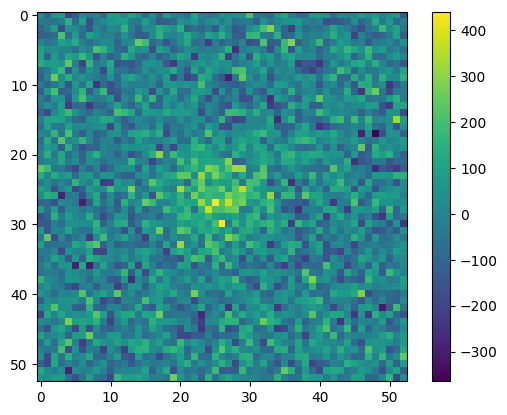

In [17]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [18]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [19]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

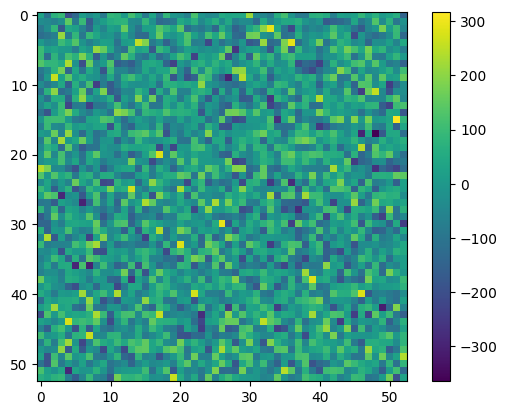

In [20]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

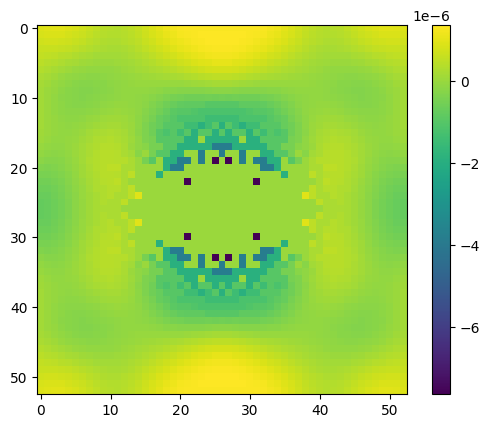

In [21]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [22]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

102 μs ± 457 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
426 μs ± 13.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [23]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [24]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 , sigma=1
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0, sigma=1
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [25]:
# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        


In [26]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 2.5

In [29]:
# what parameter space do we want to explore?
N_WARMUPS = 500 # seems good enough
MAX_DOUBLINGS = 5 # maybe good enough, 10 is a lot and probably need to explore what is good in terms of warmpu first, otherwise one chain can easily get stuck
N_CHAINS = (200, 300, 500, 800,)

In [37]:
N_SAMPLES = 100

## Run

In [38]:
SEED = 42

In [39]:
results = [] # just for n_chains

In [40]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=max(N_CHAINS,)) 
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (800, 53, 53)


In [41]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [44]:
# we create all the random keys we will need
ball_key, sample_key, warmup_key = random.split(rng_key, 3)

ball_keys = random.split(ball_key, max(N_CHAINS))
warmup_keys = random.split(warmup_key, max(N_CHAINS))
sample_keys = random.split(sample_key, max(N_CHAINS))

warmup_keys.shape

(800,)

In [45]:
all_init_positions = jax.vmap(sample_ball, in_axes=(0, None))(ball_keys, TRUE_PARAMS_GPU) # since we run 4 chains per noise realization in this case per object
all_init_positions['f'].shape

(800,)

In [46]:
# vmap only rng_key
def do_warmup(rng_key, init_position:dict, data):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, 
        is_mass_matrix_diagonal=False, 
        max_num_doublings=MAX_DOUBLINGS, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # default
    )    
    return warmup.run(rng_key, init_position, N_WARMUPS) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=MAX_DOUBLINGS).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=N_SAMPLES) # state, info
    


In [47]:

# can be resued as we fixed warmup and samples and doublings
_run_warmup =  jax.vmap(
                        jax.jit(
                                do_warmup
                        ), in_axes=(0, 0, 0)

)
_run_inference = jax.vmap(
                        jax.jit(
                                do_inference
                        ), in_axes=(0, 0, 0, 0, 0)
)


print('n_chains:')
for ii, n_chains in enumerate(N_CHAINS):
    d = {} # save results in this dictionary
    print(n_chains)

        
    # subset what we need for the n_chains
    _wkeys = warmup_keys[:n_chains]
    _skeys = sample_keys[:n_chains]
    _init_positions = {p:q[:n_chains] for p,q in all_init_positions.items()}
    _data = data_gpu[:n_chains]


    if ii == 0:
        # compilation times
        t1 = time.time()
        (_init_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data))            
        t2 = time.time()
        d['warmup_comp_time'] = t2 - t1 

        t1 = time.time()
        _ = jax.block_until_ready(_run_inference(_skeys, _init_states, _data, 
                                                            _tuned_params['step_size'], 
                                                            _tuned_params['inverse_mass_matrix']))
        t2 = time.time()
        d['inference_comp_time'] = t2 - t1 

    # run times
    t1 = time.time()
    (init_states, tuned_params), adapt_info = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data))
    t2 = time.time()
    d['warmup_run_time'] = t2 - t1 

    t1 = time.time()
    states, infos = jax.block_until_ready(_run_inference(_skeys, init_states, _data, 
                                                         tuned_params['step_size'], 
                                                         tuned_params['inverse_mass_matrix']
                                                        ))
    t2 = time.time()
    d['inference_run_time'] = t2 - t1 

    # save states and info for future reference
    d['states'] = states
    d['info'] = infos
    d['adapt_info'] = adapt_info
    d['tuned_params'] = tuned_params
    
    results.append(d)
print('DONE!')

n_chains:
200
300
500
800
DONE!


In [48]:
results[-1]['states'].position['f'].shape

(800, 100)

In [51]:
results[0]['warmup_run_time'] / 200, results[0]['inference_run_time'] / 200 / 100 * 1000

(0.4808181238174438, 0.4756063461303711)

In [52]:
results_dict = {n_chains:results[ii] for ii, n_chains in enumerate(N_CHAINS)}

## save run

In [53]:
jnp.save(f'results_benchmark-v2_5_{SEED}.npy', results_dict)